In [33]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold

In [4]:
# load in data from kaggle
players = pd.read_csv('players.csv')
teams = pd.read_csv('teams.csv')

In [5]:
players['MIN_TOTAL'] = players['MIN'] * players['GP']
teams_wins = teams[['TEAM_ID', 'SEASON', 'TEAM_NAME', 'W', 'W_PCT']]

In [6]:
# function to generate datasets
def generate_data(num_players, by, stats, rank):
    '''
    Arguments: 
    num_players = dataset will have the top num_players players
    by = the measurement to determine who are the top n players
    stats = list of columns to use
    rank = list of strings for naming

    Outputs:
    dataset
    '''
    df = players.groupby(['TEAM_ID', 'SEASON']).apply(lambda x: x.nlargest(num_players,by))[stats]
    df['num'] = rank * int(len(df) / num_players)
    df_pivot = df.pivot_table(index=['TEAM_ID', 'SEASON', 'TEAM_ABBREVIATION'], 
                             columns='num', 
                             values=stats,
                             aggfunc='first')
    df_pivot.columns = [f"{rank}_{stat}" for stat, rank in df_pivot.columns]
    df_merge = teams_wins.merge(df_pivot, on = ['TEAM_ID', 'SEASON'], how = 'inner')
    return df_merge

In [101]:
# function to run test
def test(df):
    '''
    Argument:
    df = dataset to run tests on 

    - Runs linear regression, lasso regression (CV to tune hyperparameter lambda), ridge regression (CV to tune hyperparameter lambda), KNN regression (n = 10), and XGBoost (CV to tune hyperparameters)
    - Records 10-fold CV MSE and R^2

    Output:
    row of data to be added to a dataframe
    '''
    k = 10  
    kf = KFold(n_splits=k)

    X = df.iloc[:,5:].select_dtypes(include = ['float', 'int64'])
    stats = [col[4:] for col in X.columns if col.startswith('1st_')]  # store this for calculations later
    y = df['W']
    #### LINEAR REGRESSION
    model = LinearRegression()
    linear_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    linear_mse = np.mean(-linear_scores)
    linear_r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)
    linear_r2 = np.mean(linear_r2_scores)
    #### KNN REGRESSION
    knn_regressor = KNeighborsRegressor(n_neighbors=10)
    knn_scores = cross_val_score(knn_regressor, X, y, scoring='neg_mean_squared_error', cv=kf)
    knn_mse = np.mean(-knn_scores)
    knn_r2_scores = cross_val_score(knn_regressor, X, y, scoring='r2', cv=kf)
    knn_r2 = np.mean(knn_r2_scores)
    #### RIDGE REGRESSION
    param_grid = {
        'alpha': np.logspace(-4, 4, 10)  # A range of alpha values from 0.0001 to 10000
    }
    ridge_model = Ridge()
    grid_search = GridSearchCV(estimator=ridge_model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               cv=5,
                               verbose=0,
                              n_jobs = -1)
    grid_search.fit(X, y)
    best_alpha = grid_search.best_params_['alpha']
    best_ridge_model = Ridge(alpha=best_alpha)
    ridge_scores = cross_val_score(best_ridge_model, X, y, scoring='neg_mean_squared_error', cv=kf)
    ridge_mse = np.mean(-ridge_scores)
    ridge_r2_scores = cross_val_score(best_ridge_model, X, y, scoring='r2', cv=kf)
    ridge_r2 = np.mean(ridge_r2_scores)
    #### LASSO REGRESSION
    lasso_model = Lasso()
    grid_search = GridSearchCV(estimator=lasso_model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error', 
                               cv=5,
                               verbose=0,
                              n_jobs = -1)
    grid_search.fit(X, y)
    best_alpha = grid_search.best_params_['alpha']
    best_lasso_model = Lasso(alpha=best_alpha)
    lasso_scores = cross_val_score(best_lasso_model, X, y, scoring='neg_mean_squared_error', cv=kf)
    lasso_mse = np.mean(-lasso_scores)
    lasso_r2_scores = cross_val_score(best_lasso_model, X, y, scoring='r2', cv=kf)
    lasso_r2 = np.mean(lasso_r2_scores)
    ### XGBoost
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'subsample': [0.5, 0.75, 0.9], 
        'alpha':[0.01, 0.1, 0.5, 1]
    }
    xgb = XGBRegressor()
    grid_search = GridSearchCV(estimator=xgb,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',
                               cv=5,
                               verbose=0, n_jobs = -1)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    xgb_model = XGBRegressor(**best_params)
    xgb_scores = cross_val_score(xgb_model, X, y, scoring='neg_mean_squared_error', cv=kf)
    xgb_mse = np.mean(-xgb_scores)
    xgb_r2_scores = cross_val_score(xgb_model, X, y, scoring='r2', cv=kf)
    xgb_r2 = np.mean(xgb_r2_scores)

    # store into row
    num_players = X.shape[1] / len(stats)
    num_stats = len(stats)
    row = pd.DataFrame({'num_players': num_players,
                         'num_stats': num_stats,
                         'stats' : [', '.join(stats)],
                        'linear_mse': linear_mse, 'linear_r2': linear_r2,
                       'knn_mse': knn_mse,'knn_r2' : knn_r2,
                        'ridge_mse':ridge_mse, 'ridge_r2':ridge_r2,
                        'lasso_mse':lasso_mse, 'lasso_r2':lasso_r2,
                        'xgb_mse':xgb_mse, 'xgb_r2':xgb_r2
                       })
    return row

In [102]:
## EXAMPLE USE
stats = ['TEAM_ABBREVIATION', 'PTS', 'REB', 'AST', 'POSITION','E_OFF_RATING_RANK', 'E_DEF_RATING_RANK', 'USG_PCT']
num_players = 10
by = 'MIN_TOTAL'
rank = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'][0:num_players]

test(generate_data(num_players, by, stats, rank))

,num_players,num_stats,stats,linear_mse,linear_r2,knn_mse,knn_r2,ridge_mse,ridge_r2,lasso_mse,lasso_r2,xgb_mse,xgb_r2
0,10.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",31.268219,0.80625,36.776063,0.768301,30.61922,0.811321,30.536879,0.812028,33.557154,0.795786


## Varying Number of Players

In [106]:
results = pd.DataFrame(columns = ['num_players', 'num_stats', 'stats', 'linear_mse', 'linear_r2', 
                                 'knn_mse', 'knn_r2', 'ridge_mse', 'ridge_r2', 'lasso_mse','lasso_r2',
                                 'xgb_mse', 'xgb_r2'])

In [107]:
stats = ['TEAM_ABBREVIATION', 'PTS', 'REB', 'AST', 'POSITION','E_OFF_RATING_RANK', 'E_DEF_RATING_RANK', 'USG_PCT']
by = 'MIN_TOTAL'
rank = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

for i in range(1,11):
    rank = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'][0:i]
    df = generate_data(i, by, stats, rank)
    row = test(df)
    results = pd.concat([results, row])

In [108]:
results

,num_players,num_stats,stats,linear_mse,linear_r2,knn_mse,knn_r2,ridge_mse,ridge_r2,lasso_mse,lasso_r2,xgb_mse,xgb_r2
0,1.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",44.474578,0.720366,44.300337,0.724366,44.397131,0.720517,44.204310,0.722497,48.888583,0.695536
0,2.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",41.093537,0.742374,41.100373,0.742759,40.842317,0.743529,40.830809,0.744479,43.924982,0.727489
0,3.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",39.229854,0.754403,38.872571,0.757595,39.013174,0.755684,39.151750,0.755683,40.128062,0.752432
0,4.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",36.187428,0.774071,37.637408,0.765712,36.170528,0.774184,36.183218,0.774094,38.408027,0.762993
0,5.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",34.160404,0.787607,35.808856,0.777686,34.143877,0.787704,34.163610,0.787587,35.682143,0.780601
0,6.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",33.103924,0.793514,35.347062,0.778926,33.086110,0.793624,33.106617,0.793494,35.199134,0.783019
0,7.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",33.053628,0.793195,35.841945,0.774141,32.940273,0.793887,32.869131,0.794453,35.664571,0.780807
0,8.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",31.879451,0.802354,34.830297,0.781489,31.772523,0.802977,31.877254,0.802360,34.177107,0.791607
0,9.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",31.446213,0.805054,36.322946,0.771612,30.917042,0.809276,30.868648,0.809798,34.068518,0.791056
0,10.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",31.268219,0.806250,36.776063,0.768301,30.619220,0.811321,30.536879,0.812028,33.557154,0.795786


In [109]:
results.to_csv('num_players.csv')

In [110]:
import matplotlib.pyplot as plt

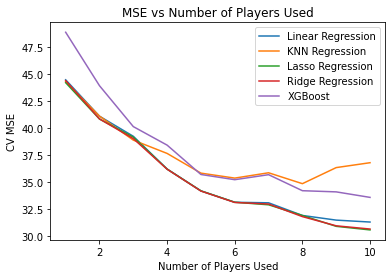

In [111]:
plt.plot(range(1,11), results['linear_mse'], label = 'Linear Regression')
plt.plot(range(1,11), results['knn_mse'], label = 'KNN Regression')
plt.plot(range(1,11), results['lasso_mse'], label = 'Lasso Regression')
plt.plot(range(1,11), results['ridge_mse'], label = 'Ridge Regression')
plt.plot(range(1,11), results['xgb_mse'], label = 'XGBoost')
plt.title('MSE vs Number of Players Used')
plt.xlabel('Number of Players Used')
plt.ylabel('CV MSE')
plt.legend()
plt.show()

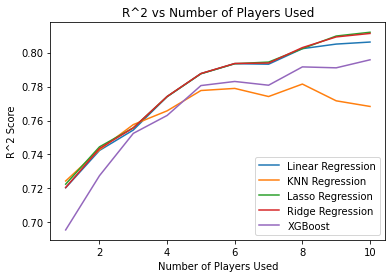

In [112]:
plt.plot(range(1,11), results['linear_r2'], label = 'Linear Regression')
plt.plot(range(1,11), results['knn_r2'], label = 'KNN Regression')
plt.plot(range(1,11), results['lasso_r2'], label = 'Lasso Regression')
plt.plot(range(1,11), results['ridge_r2'], label = 'Ridge Regression')
plt.plot(range(1,11), results['xgb_r2'], label = 'XGBoost')
plt.title('R^2 vs Number of Players Used')
plt.xlabel('Number of Players Used')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

## Varying Number of Statistics

In [114]:
results_2 = pd.DataFrame(columns = ['num_players', 'num_stats', 'stats', 'linear_mse', 'linear_r2', 
                                 'knn_mse', 'knn_r2', 'ridge_mse', 'ridge_r2', 'lasso_mse','lasso_r2',
                                 'xgb_mse', 'xgb_r2'])

In [115]:
stats = ['TEAM_ABBREVIATION', 'PTS', 'REB', 'AST', 'POSITION','E_OFF_RATING_RANK', 'E_DEF_RATING_RANK', 'USG_PCT']
by = 'MIN_TOTAL'
num_players = 10
rank = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']

for i in [2, 4, 7, 9, 13, 16, 19]:
    stats = ['TEAM_ABBREVIATION', 'PTS', 'REB', 'AST','E_OFF_RATING_RANK', 'E_DEF_RATING_RANK', 
         'USG_PCT', 'STL', 'BLK','FG3A', 'FG3M','TOV','PF', 'PIE','POSS', 'TS_PCT', 'PTS_PAINT',
        'DD2', 'TD3'][0:i]
    df = generate_data(num_players, by, stats, rank)
    row = test(df)
    results_2 = pd.concat([results_2, row])

In [116]:
results_2

,num_players,num_stats,stats,linear_mse,linear_r2,knn_mse,knn_r2,ridge_mse,ridge_r2,lasso_mse,lasso_r2,xgb_mse,xgb_r2
0,10.0,1,PTS,136.305690,0.118930,145.317326,0.068690,137.947147,0.123077,135.188660,0.137818,137.649572,0.124874
0,10.0,3,"AST, PTS, REB",129.576162,0.158053,145.947640,0.062404,128.564718,0.172152,133.292507,0.150603,137.881347,0.124358
0,10.0,6,"AST, E_DEF_RATING_RANK, E_OFF_RATING_RANK, PTS...",31.268219,0.806250,36.776063,0.768301,30.619220,0.811321,30.536879,0.812028,33.557154,0.795786
0,10.0,8,"AST, BLK, E_DEF_RATING_RANK, E_OFF_RATING_RANK...",30.567248,0.809240,36.776063,0.768301,30.304470,0.812507,30.076566,0.813503,34.019753,0.792076
0,10.0,12,"AST, BLK, E_DEF_RATING_RANK, E_OFF_RATING_RANK...",30.909586,0.805814,36.804248,0.768178,29.584643,0.817664,29.377221,0.817542,33.415351,0.796147
0,10.0,15,"AST, BLK, E_DEF_RATING_RANK, E_OFF_RATING_RANK...",19.005043,0.875733,53.208867,0.662999,18.980514,0.875858,18.613564,0.877792,22.435184,0.857589
0,10.0,18,"AST, BLK, DD2, E_DEF_RATING_RANK, E_OFF_RATING...",19.923298,0.869089,53.207292,0.663051,19.891487,0.869282,19.822571,0.869659,22.817687,0.852497


In [58]:
results_2.to_csv('num_stats.csv')

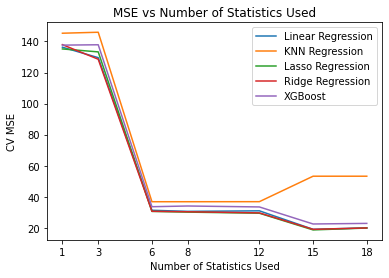

In [117]:
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['linear_mse'], label = 'Linear Regression')
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['knn_mse'], label = 'KNN Regression')
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['lasso_mse'], label = 'Lasso Regression')
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['ridge_mse'], label = 'Ridge Regression')
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['xgb_mse'], label = 'XGBoost')
plt.title('MSE vs Number of Statistics Used')
plt.xlabel('Number of Statistics Used')
plt.ylabel('CV MSE')
plt.xticks([1, 3, 6, 8, 12, 15, 18])
plt.legend()
plt.show()

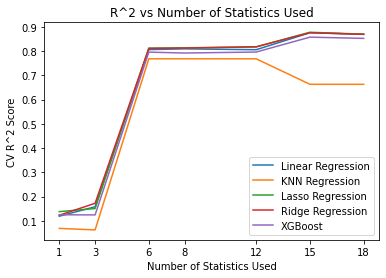

In [118]:
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['linear_r2'], label = 'Linear Regression')
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['knn_r2'], label = 'KNN Regression')
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['lasso_r2'], label = 'Lasso Regression')
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['ridge_r2'], label = 'Ridge Regression')
plt.plot([1, 3, 6, 8, 12, 15, 18], results_2['xgb_r2'], label = 'XGBoost')
plt.title('R^2 vs Number of Statistics Used')
plt.xlabel('Number of Statistics Used')
plt.ylabel('CV R^2 Score')
plt.xticks([1, 3, 6, 8, 12, 15, 18])
plt.legend()
plt.show()

## Exploring Feature Importance

In [119]:
stats = ['TEAM_ABBREVIATION', 'PTS', 'REB', 'AST','E_OFF_RATING_RANK', 'E_DEF_RATING_RANK', 
         'USG_PCT', 'STL', 'BLK','FG3A', 'FG3M','TOV','PF', 'PIE','POSS', 'TS_PCT']
df = generate_data(10, by, stats, rank)
X = df.iloc[:,5:].select_dtypes(include = ['float', 'int64'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
y = df['W']
#X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2, random_state=100)
#### LINEAR REGRESSION
model = LinearRegression()
# Fit the model to the training data
model.fit(scaled_data, y)

LinearRegression()

In [120]:
coefficients = model.coef_
# Find the indices of the 5 largest coefficients (in absolute value)
top_5_indices = np.argsort(np.abs(coefficients))[-10:]

# Get the top 5 coefficients and their corresponding indices
top_5_coefficients = coefficients[top_5_indices]
top_5_variables = X.columns[top_5_indices]

# Print the results
for var, coef in zip(top_5_variables, top_5_coefficients):
    print(f"{var}: Coefficient {coef}")

2nd_USG_PCT: Coefficient -1.5176540151087523
7th_PIE: Coefficient 1.5782960862738662
1st_POSS: Coefficient 1.6963074672471894
1st_REB: Coefficient -1.7817859961584968
3rd_PIE: Coefficient 1.8471571991224462
2nd_FG3M: Coefficient -1.8904545677604339
1st_PTS: Coefficient -1.9655756623796823
2nd_FG3A: Coefficient 2.06644937175388
2nd_PIE: Coefficient 2.2630969709068447
1st_PIE: Coefficient 4.923235715436582


In [122]:
stats = ['PTS', 'REB', 'AST','E_OFF_RATING_RANK', 'E_DEF_RATING_RANK', 
         'USG_PCT', 'STL', 'BLK','FG3A', 'FG3M','TOV','PF', 'PIE','POSS', 'TS_PCT']
for stat in stats:
    columns_with_stats = [col for col in X.columns if stat in col]
    coefficients_stats = {col: coef for col, coef in zip(X.columns, coefficients) if col in columns_with_stats}
    mean = np.mean([abs(i) for i in coefficients_stats.values()])
    print(f"{stat}: Coefficient {mean}")

PTS: Coefficient 0.6155352522492923
REB: Coefficient 0.5251328677467664
AST: Coefficient 0.40768201643022073
E_OFF_RATING_RANK: Coefficient 0.49406392194626986
E_DEF_RATING_RANK: Coefficient 0.5576434646083077
USG_PCT: Coefficient 0.45551299612300317
STL: Coefficient 0.17830610912962713
BLK: Coefficient 0.17189187761779698
FG3A: Coefficient 0.775670050875583
FG3M: Coefficient 0.8132313944648132
TOV: Coefficient 0.4126245288274502
PF: Coefficient 0.23647032182427927
PIE: Coefficient 1.4805409723420244
POSS: Coefficient 0.5162686941154607
TS_PCT: Coefficient 0.26914879807819414


In [123]:
rank = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']
means = []
for r in rank:
    columns_with_r = [col for col in X.columns if r in col]
    coeffbicients_r = {col: coef for col, coef in zip(X.columns, coefficients) if col in columns_with_r}
    means.append(np.mean([abs(i) for i in coefficients_r.values()]))

In [124]:
d = pd.DataFrame({'stat':rank, 'coef':means})
d.sort_values('coef', ascending = False)

,stat,coef
0,1st,0.312061
1,2nd,0.312061
2,3rd,0.312061
3,4th,0.312061
4,5th,0.312061
5,6th,0.312061
6,7th,0.312061
7,8th,0.312061
8,9th,0.312061
9,10th,0.312061


In [125]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.75, 0.9], 
    'alpha':[0.01, 0.1, 0.5, 1]
}
xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=0, n_jobs = -1)
grid_search.fit(X, y)
best_params = grid_search.best_params_
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X,y)

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

In [126]:
importance = xgb_model.feature_importances_
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
for stat in stats:
    mean = importance_df[importance_df['Feature'].str.contains(stat)]['Importance'].mean()
    print(f"{stat} : {mean}")

PTS : 0.0027583923656493425
REB : 0.0013164521660655737
AST : 0.0009410142083652318
E_OFF_RATING_RANK : 0.03652035444974899
E_DEF_RATING_RANK : 0.028831880539655685
USG_PCT : 0.001985277747735381
STL : 0.0015866702888160944
BLK : 0.0015319507801905274
FG3A : 0.002725177677348256
FG3M : 0.0025526557583361864
TOV : 0.0016029855469241738
PF : 0.0018517009448260069
PIE : 0.0028877330478280783
POSS : 0.009589024819433689
TS_PCT : 0.0033187351655215025


In [127]:
for r in rank:
    mean = importance_df[importance_df['Feature'].str.contains(r)]['Importance'].mean()
    print(f"{r} : {mean}")

1st : 0.022401932626962662
2nd : 0.01073248591274023
3rd : 0.0067438348196446896
4th : 0.00505084777250886
5th : 0.007156762760132551
6th : 0.003131160279735923
7th : 0.002939374651759863
8th : 0.004151991102844477
9th : 0.002596576465293765
10th : 0.001761699910275638
